In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
import tensorflow as tf 
from tensorflow import keras
import csv
import os
from keras import backend as K
import math
from scipy.stats import norm
import os
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cutoff = 11100
#this is the length I'm cutting off the data just arbitrarily when I'm using multiple catalogs
#but here since i'm only using one it doesn't matter 

master_rshift = []
master_dist_mod = [] #errors added on 
master_glat = [] 
master_glon = [] 
bulkflows = [] 
#I use this to determine the shortest length of data when using varied catalogs 

for x in os.listdir("/content/drive/My Drive/Rotated new all same"):
    data = np.load("/content/drive/My Drive/Rotated new all same/"+x)
    master_rshift.append(data['redshift'][:cutoff])
    master_dist_mod.append(data['distm'][:cutoff] + data['distmerr'][:cutoff])
    master_glat.append(data['glat'][:cutoff])
    master_glon.append(data['glon'][:cutoff])
    bulkflows.append(data['bulkflow'])
    
master_bulkflows = np.array(bulkflows) #cutoff is number of files 

#I scale the data to be between 0 and 1 here, where I am scaling it by the 
#largest value of all the data, as opposed to scaling each by 
#the maximum of that array respectively 
#not sure if this is the best approach? 

redshift = np.array(master_rshift)/np.max(np.concatenate(np.array(master_rshift))) 
distm = np.array(master_dist_mod)/np.max(np.concatenate(np.array(master_dist_mod)))
glat = np.array(master_glat)/np.max(np.concatenate(np.array(master_glat)))
glon = np.array(master_glon)/np.max(np.concatenate(np.array(master_glon)))

x_max = max(master_bulkflows[:,0])
y_max = max(master_bulkflows[:,1])
z_max = max(master_bulkflows[:,2])

master_bulkflows_scaled = [] 
for x in master_bulkflows: 
    master_bulkflows_scaled.append(x/(np.array([x_max,y_max,z_max])))
    
#Here I am preparing the data into it's training and testing sets 

X = np.stack([redshift,distm,glat,glon],axis=-1) #used to be -1
y = np.array(master_bulkflows_scaled)
train_percent = 0.6
X_train,X_test = (X[:int(len(X)*train_percent)], X[int(len(X)*train_percent)::])
y_train,y_test = (y[:int(len(y)*train_percent)], y[int(len(y)*train_percent)::])

In [5]:
#okay this is where it gets messy 
#so I had to write the program in a bit different formalism for it to work but it seems to mean the same 
#the below is the input, which is the size of the amount of arrays in each catalog
#with the 4 being the size of each of those arrays (rshift, distmod, glat, glon)

inputs = tf.keras.Input(shape=X_train.shape[1:])

#here, it's like adding a first layer, where the (inputs) means you're putting the last thru this one 
x = tf.keras.layers.Conv1D(64, 16, activation='tanh')(inputs)
#print(x.shape)
#here you're doing the same thing, putting the last (x) in this new layer (x2) 
#the input shape is from the shape that the previous (x) CONV layer outputs 
#I don't know quite what the shape *means*, but you have to basically have the 
#input shape of a layer be whatever shape the last one output 
x2 = tf.keras.layers.Conv1D(32, 6, input_shape=x.shape[1:], activation='tanh')(x)
#print(x2.shape[1:])
x3 = tf.keras.layers.Conv1D(32, 4, input_shape=x2.shape[1:], activation='tanh')(x2)
#now to put in our last layer, the dense layer, we have to flatten it to get our 3D single arrays 
#Flatten is itself a type of layer 
x4 = tf.keras.layers.Flatten()(x3)

outputs = tf.keras.layers.Dense(3,activation='linear')(x4)

model1 = tf.keras.Model(inputs=inputs,outputs=outputs)
optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model1.fit(X_train,y_train,epochs=2)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


57/57 [==============================] - 76s 1s/step - loss: 0.1184 - accuracy: 0.7583
Epoch 2/2
57/57 [==============================] - 76s 1s/step - loss: 0.0899 - accuracy: 0.7994


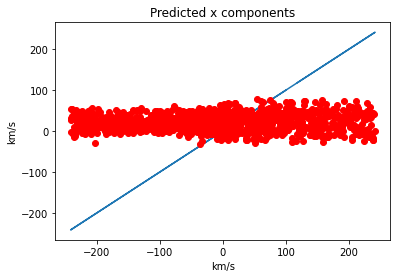

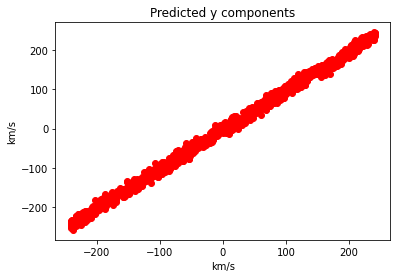

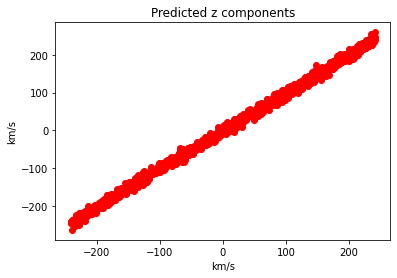

In [6]:
y_pred = model1.predict(X_test)
plt.plot(y_test[:,0]*x_max,y_test[:,0]*x_max)
plt.plot(y_test[:,0]*x_max,y_pred[:,0]*x_max,'ro')
#plt.ylim(-15,0)
plt.title('Predicted x components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,1]*y_max,y_test[:,1]*y_max)
plt.plot(y_test[:,1]*y_max,y_pred[:,1]*y_max,'ro')
#plt.ylim(-5,10)
plt.title('Predicted y components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,2]*z_max,y_test[:,2]*z_max)
plt.plot(y_test[:,2]*z_max,y_pred[:,2]*z_max,'ro')
#plt.ylim(-10,2)
plt.title('Predicted z components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

In [7]:
x_preds = y_pred[:,0]*x_max
y_preds = y_pred[:,1]*y_max
z_preds = y_pred[:,2]*z_max

bulkflows_pred = np.sqrt(x_preds**2 + y_preds**2 + z_preds**2)
bulkflows_pred_yz = np.sqrt(y_preds**2 + z_preds**2)

x_true = y_test[:,0]*x_max
y_true = y_test[:,1]*y_max
z_true = y_test[:,2]*z_max

bulkflows_true = np.sqrt(x_true**2 + y_true**2 + z_true**2)
bulkflows_true_yz = np.sqrt(y_true**2 + z_true**2)

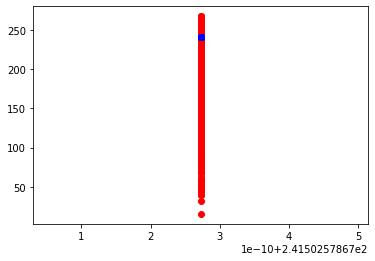

In [8]:
plt.plot(bulkflows_true,bulkflows_pred,'ro')
plt.plot(bulkflows_true,bulkflows_true,'bo')

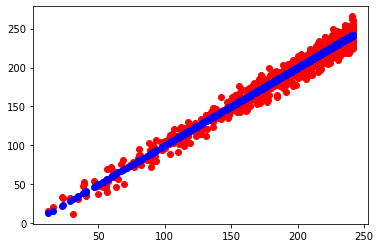

In [9]:
plt.plot(bulkflows_true_yz,bulkflows_pred_yz,'ro')
plt.plot(bulkflows_true_yz,bulkflows_true_yz,'bo')